<a href="https://colab.research.google.com/github/frosinastojanovska/cryosiam_beta/blob/main/tomogram_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

## Step 1. Installation

In [ ]:
#@markdown ## 1.1. Run this cell to connect your Google Drive to colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown You will either have to:
#@markdown * copy the authorisation code and enter it into box below OR

#@markdown * in the new google colab, you can just click "Allow" and it should connect.

#@markdown * Click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

#@markdown ## 1.2. Run this cell to install necessary packages

#@markdown The code in this cell:
#@markdown * Gets the git repository of CryoSiam-beta

!git clone https://github.com/frosinastojanovska/cryosiam_beta.git

#@markdown * Installs required packages
!pip install monai
!pip install mrcfile

Cloning into 'cryosiam_beta'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 40 (delta 6), reused 37 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 20.98 KiB | 10.49 MiB/s, done.
Resolving deltas: 100% (6/6), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00


##Step 2. Predict with trained neural network

In [ ]:
#@markdown ## 2.1. Preprocess the tomogram to invert and scale the intensities
# @markdown * **Path to the folder with tomogram .mrc file/s (make sure the tomogram is around 6.8 A/px)**:
input_path = '/content/gdrive/MyDrive/tomo_data/' #@param {type:"string"}
# @markdown * **Path to where to save the output .mrc file**:
out_path = '/content/gdrive/MyDrive/tomo_data_inverted_scaled/' #@param {type:"string"}
lower_end_percentage = 0.1
upper_end_percentage = 99.9

import os
import mrcfile
import numpy as np

os.makedirs(out_path, exist_ok=True)

#!python /content/cryosiam_beta/cryosiam/apps/preprocessing/revert_and_scale_intensity.py --input_path={tomogram_path} --output_path=${out_path} --invert --lower_end_percentage 0.1 --upper_end_percentage 99.9
def invert_tomogram(tomo):
    return tomo * -1


def scale_tomogram(tomo, percentile_lower=None, percentile_upper=None):
    if percentile_lower:
        min_val = np.percentile(tomo, percentile_lower)
    else:
        min_val = tomo.min()

    if percentile_upper:
        max_val = np.percentile(tomo, percentile_upper)
    else:
        max_val = tomo.max()

    tomo = (tomo - min_val) / (max_val - min_val)

    return np.clip(tomo, 0, 1)

if os.path.isdir(input_path):
    os.makedirs(out_path, exist_ok=True)
    for tomo in os.listdir(input_path):
        if tomo.endswith(".mrc") or tomo.endswith(".rec"):
            with mrcfile.open(os.path.join(input_path, tomo), permissive=True) as m:
                tomogram = m.data
                voxel_size = m.voxel_size
            tomogram = invert_tomogram(tomogram)
            tomogram = scale_tomogram(tomogram, lower_end_percentage, upper_end_percentage)

            with mrcfile.new(os.path.join(out_path, tomo), overwrite=True) as m:
                m.set_data(tomogram)
                m.voxel_size = voxel_size
else:
    with mrcfile.open(input_path, permissive=True) as m:
        tomogram = m.data
        voxel_size = m.voxel_size
    tomogram = invert_tomogram(tomogram)

    tomogram = scale_tomogram(tomogram, lower_end_percentage, upper_end_percentage)

    with mrcfile.new(out_path, overwrite=True) as m:
        m.set_data(tomogram)
        m.voxel_size = voxel_size

del tomogram


In [ ]:
#@markdown ## 2.2. Denoise the inverted and scaled tomogram with the trained model
# @markdown * **Path where to save the output**:
output_denoised_path = '/content/gdrive/MyDrive/tomo_data_denoised' #@param {type:"string"}

model_path = "https://www.dropbox.com/scl/fi/sxobvwa7k2ju54aimexhr/denoising_model.ckpt?rlkey=u2m4lv07rmfxmwcv6rf9uqaot&st=i12gjlxd&dl=0"
!wget -O model.ckpt {model_path}


import yaml
original_config_file = '/content/cryosiam_beta/cryosiam/apps/dense_simsiam_regression/config_test.yaml'

def read_yaml(file_path):
    with open(file_path, "r") as stream:
        data = yaml.safe_load(stream)
    return data

def save_yaml(data, file_path):
    with open(file_path, 'w') as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

d = read_yaml(original_config_file)
d['data_folder'] = out_path
d['log_folder'] = output_denoised_path
d['prediction_folder'] = output_denoised_path
d['trained_model'] = 'model.ckpt'
d['test_files'] = None
d['hyper_parameters']['batch_size']=20
user_config_file = '/content/cryosiam_beta/cryosiam/apps/dense_simsiam_regression/config.yaml'
save_yaml(d, user_config_file)

import sys
sys.path.insert(1, "/content/cryosiam_beta")
import os
os.environ['PATH'] += '/content/cryosiam_beta'
from cryosiam.apps.dense_simsiam_regression.predict import main
main(user_config_file)


--2024-08-27 16:44:20--  https://www.dropbox.com/scl/fi/sxobvwa7k2ju54aimexhr/denoising_model.ckpt?rlkey=u2m4lv07rmfxmwcv6rf9uqaot
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3534606a005376177d5a25a0fb.dl.dropboxusercontent.com/cd/0/inline/CZfzvZV920PXs2StJ0bHP0hVOTtLm45ikCNBSU348ZRaTWhA7HN50DXoTYT6wOhuLjFeeLkyGKWCfE9AiD9S-WIt6q-_J6Ad0jeXvKgVp6vyye1QYiGDFiMkbjW1fkkjNJpWAvt-zIyNXlRe8g7wbP5f/file# [following]
--2024-08-27 16:44:21--  https://uc3534606a005376177d5a25a0fb.dl.dropboxusercontent.com/cd/0/inline/CZfzvZV920PXs2StJ0bHP0hVOTtLm45ikCNBSU348ZRaTWhA7HN50DXoTYT6wOhuLjFeeLkyGKWCfE9AiD9S-WIt6q-_J6Ad0jeXvKgVp6vyye1QYiGDFiMkbjW1fkkjNJpWAvt-zIyNXlRe8g7wbP5f/file
Resolving uc3534606a005376177d5a25a0fb.dl.dropboxusercontent.com (uc3534606a005376177d5a25a0fb.dl.dropboxusercontent.com)... 162.125.8

/content/cryosiam_beta/cryosiam/apps/dense_simsiam_regression/utils.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/content/cr

Prediction


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/monai/utils/type_conversion.py:141: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  tensor = torch.as_tensor(tensor, **kwargs)


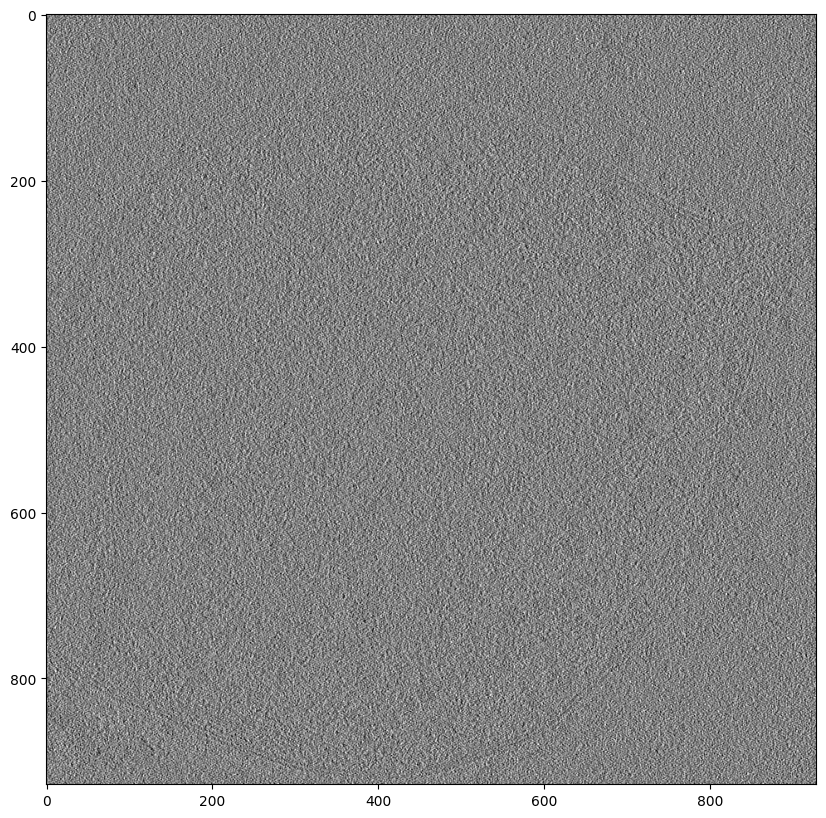

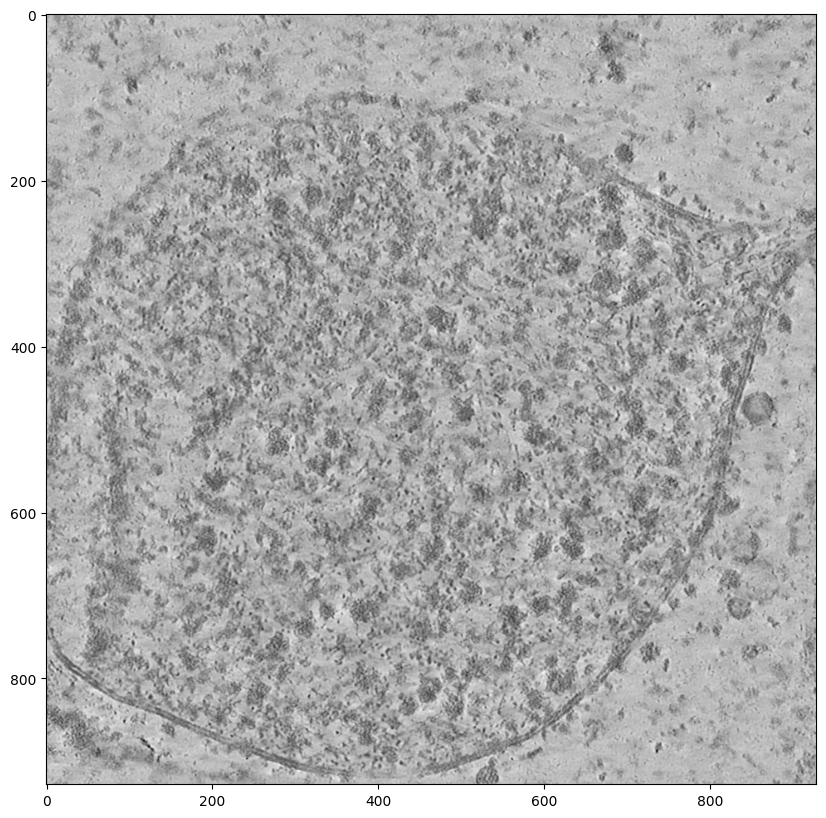

In [8]:
#@markdown ## Step 3. Visualize the prediction
#@markdown Run this cell to do visualization of particular z axis

tomo_name = 'TS_29.mrc' #@param {type:"string"}
z_axis = 50 #@param {type:"integer"}

import os
import mrcfile


def read_tomogram(filename):
    with mrcfile.open(filename, permissive=True) as m:
        return m.data

tomogram = read_tomogram(os.path.join(out_path, tomo_name))
denoised_tomogram = read_tomogram(os.path.join(output_denoised_path, tomo_name))

import numpy as np
import matplotlib.pyplot as plt

# First figure
plt.figure(figsize = (10,10))
plt.imshow(tomogram[z_axis] * -1, cmap='gray')

# Second figure
plt.figure(figsize = (10,10))
plt.imshow(denoised_tomogram[z_axis] * -1, cmap='gray')